In [1]:
# %reset-f
%load_ext autoreload
%autoreload 2

In [28]:
from res_ind_lib import *

from sorted_nicely import *
from replace_with_warning import *

import os, time
import warnings
warnings.filterwarnings("always",category=UserWarning)
from wb_api_wraper import *

In [3]:
import numpy as np
import pandas as pd

#Pandas display options
# pd.set_option('display.max_colwidth', 200)
# pd.set_option('display.width', 200)
# pd.set_option('display.precision', 10)
# pd.set_option('display.max_rows', 500)

#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 15}
plt.rc('font', **font)

from fancy_plots import *

In [4]:
#Names to WB names
any_to_wb = pd.read_csv("inputs/any_name_to_wb_name.csv",index_col="any",squeeze=True)

#GAR names with SIDS spec
gar_name_sids = pd.read_csv("inputs/gar_name_sids.csv")

#iso3 to wb country name table
iso3_to_wb=pd.read_csv("inputs/iso3_to_wb_name.csv").set_index("iso3").squeeze()

#iso2 to iso3 table
iso2_iso3 = pd.read_csv("inputs/names_to_iso.csv", usecols=["iso2","iso3"]).drop_duplicates().set_index("iso2").squeeze() #the tables has more lines than countries to account for several ways of writing country names

In [20]:
gar_name_sids['wbcountry'] = gar_name_sids.reset_index().country.replace(any_to_wb)

list_of_sids = gar_name_sids[gar_name_sids.isaSID=="SIDS"].dropna().reset_index().wbcountry

In [30]:
penn = pd.read_excel("inputs/pwt90.xlsx","Data")

In [31]:
penn.columns

Index(['countrycode', 'country', 'currency_unit', 'year', 'rgdpe', 'rgdpo',
       'pop', 'emp', 'avh', 'hc', 'ccon', 'cda', 'cgdpe', 'cgdpo', 'ck',
       'ctfp', 'cwtfp', 'rgdpna', 'rconna', 'rdana', 'rkna', 'rtfpna',
       'rwtfpna', 'labsh', 'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo',
       'i_cig', 'i_xm', 'i_xr', 'i_outlier', 'cor_exp', 'statcap', 'csh_c',
       'csh_i', 'csh_g', 'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g',
       'pl_x', 'pl_m', 'pl_k'],
      dtype='object')

In [67]:
def mrv_gp_2(x):
    """this function gets the most recent value from a dataframe grouped by country"""
    out= x.ix[(x["year"])==np.max(x["year"]),:]
    return out

In [68]:
hop=penn.groupby("country").apply(mrv_gp_2)
hop = hop.drop("country",axis=1).reset_index().drop("level_1",axis=1)

In [87]:
clean_penn = hop[['countrycode', 'country', 'year', 'cgdpo', 'ck']].copy()

In [88]:
clean_penn.head()

,countrycode,country,year,cgdpo,ck
0,ALB,Albania,2014,31419.962891,1.127928e+05
1,DZA,Algeria,2014,497452.875000,1.721824e+06
2,AGO,Angola,2014,205371.265625,7.960541e+05
3,AIA,Anguilla,2014,294.655243,3.296041e+03
4,ATG,Antigua and Barbuda,2014,1363.846924,1.177330e+04


In [89]:
clean_penn["country"] = clean_penn.country.replace(any_to_wb)

In [90]:
K_sids = clean_penn.set_index("country").loc[list_of_sids,:]

In [141]:
GAR = pd.read_csv("inputs/GAR_capital.csv")

In [142]:
GAR["country"] = GAR.country.replace(any_to_wb)

In [143]:
gar_sids = GAR.set_index("country").loc[list_of_sids,:].replace(0, np.nan).dropna()

In [144]:
all_K_sids = pd.concat([gar_sids,K_sids],axis=1)

In [145]:
all_K_sids = all_K_sids.loc[(all_K_sids != 0).any(axis=1),:]

In [146]:
all_K_sids.columns

Index(['GDP', 'K', 'GFCF', 'countrycode', 'year', 'cgdpo', 'ck'], dtype='object')

In [147]:
all_K_sids["prod_k_1"] = all_K_sids.GDP/all_K_sids.K
all_K_sids["prod_k_2"] = all_K_sids.cgdpo/all_K_sids.ck

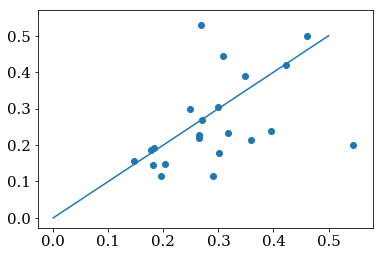

In [151]:
plt.scatter(all_K_sids.prod_k_1,all_K_sids.prod_k_2)
plt.plot([0,0.5],[0,0.5])

In [152]:
all_K_sids["avg_prod_k"] = all_K_sids.prod_k_2
all_K_sids.avg_prod_k = all_K_sids.avg_prod_k.fillna(all_K_sids.prod_k_1)

In [153]:
all_K_sids.avg_prod_k

American Samoa                         NaN
Anguilla                          0.089397
Antigua and Barbuda               0.115842
Aruba                             0.114948
Bahamas, The                      0.186616
Bahrain                           0.231960
Barbados                          0.178715
Belize                            0.528741
Bermuda                           0.186163
Cape Verde                        0.219569
Cayman Islands                    0.018669
Comoros                           0.500564
Cuba                              0.390089
Dominica                          0.299555
Dominican Republic                0.303405
Fiji                              0.389214
French Polynesia                       NaN
Grenada                           0.191777
Guinea-Bissau                     0.418666
Guyana                            0.380848
Haiti                             0.133367
Jamaica                           0.147687
Kiribati                          0.283950
Maldives   

In [154]:
all_K_sids.avg_prod_k.dropna().to_csv("intermediate/avg_prod_k_sids.csv")